In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import datasets, transforms, models
from torchvision.transforms import v2
import os
import PIL
import cv2
from tqdm import tqdm

In [2]:
cwd = os.getcwd()
cwd

'/sfs/gpfs/tardis/home/frv3fp/Documents/DS6050/Project'

In [3]:
if 'kbk8vh' in cwd:
  os.chdir('/sfs/gpfs/tardis/home/kbk8vh/Documents/MSDS/DS6050/Project/input')
  DIR = '/sfs/gpfs/tardis/home/kbk8vh/Documents/MSDS/DS6050/Project/input/toxic-plant-classification/tpc-imgs/'
if 'jsk2zs' in cwd:
    os.chdir('/sfs/gpfs/tardis/home/jsk2zs/Project/input')
    DIR = '/sfs/gpfs/tardis/home/jsk2zs/Project/input/toxic-plant-classification/tpc-imgs/'
if 'frv3fp' in cwd:
  os.chdir('/sfs/gpfs/tardis/home/frv3fp/Documents/DS6050/Project/input')
  DIR = '/sfs/gpfs/tardis/home/frv3fp/Documents/DS6050/Project/input/toxic-plant-classification/tpc-imgs/'
elif 'content' in cwd:
  from google.colab import drive
  drive.mount('/content/drive')
  os.chdir('/content/drive/My Drive/DS6050/Project/input')
  DIR = '/content/drive/My Drive/DS6050/Project/input/toxic-plant-classification/tpc-imgs/'
else:
  print('Directory?')
DIR

'/sfs/gpfs/tardis/home/frv3fp/Documents/DS6050/Project/input/toxic-plant-classification/tpc-imgs/'

## Loading Data

In [4]:
toxic_meta = pd.read_csv(DIR + 'toxic_metadata.csv')
nontoxic_meta = pd.read_csv(DIR + 'nontoxic_metadata.csv')
full_meta = pd.read_csv(DIR + 'full_metadata.csv')

print('Full dataset shape: ' + str(full_meta.shape))
full_meta.head()

Full dataset shape: (9952, 7)


class_id             slang              scientific_name  \
0         0  Virginia creeper  Parthenocissus quinquefolia   
1         0  Virginia creeper  Parthenocissus quinquefolia   
2         0  Virginia creeper  Parthenocissus quinquefolia   
3         0  Virginia creeper  Parthenocissus quinquefolia   
4         0  Virginia creeper  Parthenocissus quinquefolia   

   herbarium22_category_id                                               path  \
0                    10340  ../input/toxic-plant-classification/tpc-imgs/n...   
1                    10340  ../input/toxic-plant-classification/tpc-imgs/n...   
2                    10340  ../input/toxic-plant-classification/tpc-imgs/n...   
3                    10340  ../input/toxic-plant-classification/tpc-imgs/n...   
4                    10340  ../input/toxic-plant-classification/tpc-imgs/n...   

   toxicity  species_label  
0         0              3  
1         0              3  
2         0              3  
3         0              3  
4         0              3

## Dataset verification

The dataset downloaded frmom Kaggle contains ten different plant species, five toxic species and five non-toxic species. Each of the ten classes contain roughly 1,000 images. Seven classes contain exactly 1,000 images. Three classes (Fragrant Sumac,  Poison Sumac, and Eastern Poison Oak) contain less than 1,000 images (999, 999, and 954 images, respectively). **Maybe add some visualizations?**

The dataset explicitly labels plants as non-toxic (0) or toxic (1). The classes are approximately balanced, with 4,999 images of non-toxic plants and 4,953 images of toxic plants.

In [5]:
full_meta['toxicity'].value_counts()

toxicity
0    4999
1    4953
Name: count, dtype: int64

In [6]:
full_meta.groupby('toxicity')['slang'].value_counts()

toxicity  slang             
0         Bear Oak              1000
          Boxelder              1000
          Jack-in-the-pulpit    1000
          Virginia creeper      1000
          Fragrant Sumac         999
1         Eastern Poison Ivy    1000
          Western Poison Ivy    1000
          Western Poison Oak    1000
          Poison Sumac           999
          Eastern Poison Oak     954
Name: count, dtype: int64

## Validation Split

The dataset was split using a 70/15/15 train/validation/test split, stratified by both species and toxicity.

In [7]:
# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

In [8]:
# Dataset parameters
batch_size = 32
img_height = 150
img_width = 150
num_classes = 2 # (or 10 if species?)

# Class names for toxic vs. non-toxic
class_names = ['Toxic', 'Non-Toxic']

# Data transforms
train_transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_transform_strong = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.v2.CutMix(num_classes=2, alpha=1.0),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create full dataset
full_dataset = datasets.ImageFolder(DIR)

# Training indexes (0.7) and temporary indexes (0.3, which will be split into 0.15 and 0.15)
train_idx, temp_idx = train_test_split(full_meta.index,
                                       test_size=0.3,
                                       random_state=42,
                                       stratify=full_meta[['toxicity', 'scientific_name']])
temp_meta = full_meta.loc[temp_idx]

# Validation indexes (0.15) and test indexes (0.15)
val_idx, test_idx = train_test_split(temp_idx,
                                     test_size=0.5,
                                     random_state=42,
                                     stratify=temp_meta[['toxicity', 'scientific_name']])

# Create subsets for train, val, test
train_dataset = Subset(full_dataset, train_idx)
train_dataset_strong_aug = Subset(full_dataset, train_idx)
val_dataset = Subset(full_dataset, val_idx)
test_dataset = Subset(full_dataset, test_idx)

# Apply transforms
train_dataset.dataset.transform = train_transform
train_dataset_strong_aug.dataset.transform = train_transform_strong
val_dataset.dataset.transform = val_transform
test_dataset.dataset.transform = val_transform

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
train_strong_loader = DataLoader(train_dataset_strong_aug, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Training samples: {len(train_dataset)} ({int(100*(len(train_dataset)/len(full_dataset)))}%)")
print(f"Validation samples: {len(val_dataset)} ({int(100*(len(val_dataset)/len(full_dataset)))}%)")
print(f"Test samples: {len(test_dataset)} ({int(100*(len(test_dataset)/len(full_dataset)))}%)")

Training samples: 6966 (69%)
Validation samples: 1493 (15%)
Test samples: 1493 (15%)


### Ensuring the datasets are stratified by toxicity and species.

In [9]:
# Train
full_meta.iloc[train_idx].groupby('toxicity')['slang'].value_counts()

toxicity  slang             
0         Bear Oak              700
          Boxelder              700
          Jack-in-the-pulpit    700
          Virginia creeper      700
          Fragrant Sumac        699
1         Eastern Poison Ivy    700
          Western Poison Ivy    700
          Western Poison Oak    700
          Poison Sumac          699
          Eastern Poison Oak    668
Name: count, dtype: int64

In [10]:
# Validation
full_meta.iloc[val_idx].groupby('toxicity')['slang'].value_counts()

toxicity  slang             
0         Bear Oak              150
          Boxelder              150
          Fragrant Sumac        150
          Jack-in-the-pulpit    150
          Virginia creeper      150
1         Eastern Poison Ivy    150
          Poison Sumac          150
          Western Poison Ivy    150
          Western Poison Oak    150
          Eastern Poison Oak    143
Name: count, dtype: int64

In [11]:
# Test
full_meta.iloc[test_idx].groupby('toxicity')['slang'].value_counts()

toxicity  slang             
0         Bear Oak              150
          Boxelder              150
          Fragrant Sumac        150
          Jack-in-the-pulpit    150
          Virginia creeper      150
1         Eastern Poison Ivy    150
          Poison Sumac          150
          Western Poison Ivy    150
          Western Poison Oak    150
          Eastern Poison Oak    143
Name: count, dtype: int64

## Baseline model

A random forest baseline model was used to assess if the use of deep learning methods is necessary.

Inspo: https://www.geeksforgeeks.org/machine-learning/random-forest-for-image-classification-using-opencv/

https://www.youtube.com/watch?v=zSbXfnQPx_k

### Color histogram

In [12]:
# Method 1
def color_histogram(img, bins=(256, 256, 256)):
    hist = cv2.calcHist([img], [0, 1, 2], None, bins, [0,256, 0,256, 0,256])
    cv2.normalize(hist, hist)
    return hist.flatten()

In [13]:

# # Color histogram other methods

# img = cv2.imread('/sfs/gpfs/tardis/home/kbk8vh/Documents/MSDS/DS6050/Project/input/toxic-plant-classification/tpc-imgs/toxic_images/004/000.jpg')#cv2.imread('../input/toxic-plant-classification/tpc-imgs/toxic_images/004/000.jpg')

# # Method 2: Calculate histograms for each channel
# b, g, r = cv2.split(img)
# # Parameters: [image], [channels], mask, [histSize], [ranges]
# hist_b = cv2.calcHist([b], [0], None, [8], [0, 256])
# hist_g = cv2.calcHist([g], [0], None, [8], [0, 256])
# hist_r = cv2.calcHist([r], [0], None, [8], [0, 256])

# # Plotting the histograms (optional)
# plt.figure(figsize=(10, 5))
# plt.title('Color Histograms')
# plt.plot(hist_b, color='blue', label='Blue')
# plt.plot(hist_g, color='green', label='Green')
# plt.plot(hist_r, color='red', label='Red')
# plt.xlabel('Pixel Intensity')
# plt.ylabel('Frequency')
# plt.legend()
# plt.show()

# # Method 3
# def color_histogram2(img, bins=256):
#   imgRBG = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#   colors = ['r', 'g', 'b']

#   for i in range(len(colors)):
#     hist = cv2.calcHist([imgRBG], [i], None, [bins], [0, 256])
#     #cv2.normalize(hist, hist)
#     plt.plot(hist, color=colors[i])

#   plt.xlabel('Pixel Intensity')
#   plt.ylabel('# of Pixels')
#   plt.show()
#   return

### GLCM Texture

In [14]:
from skimage.feature import graycomatrix, graycoprops

def glcm_texture(img):
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  glcm = graycomatrix(gray, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4])
  energy = graycoprops(glcm, 'energy')[0, 0]
  homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
  correlation = graycoprops(glcm, 'correlation')[0, 0]
  contrast = graycoprops(glcm, 'contrast')[0, 0]
  dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
  return energy, homogeneity, correlation, contrast, dissimilarity

### Shape features (circularity, aspect ratio)

In [15]:
def shape_features(img):
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  contours, _ = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  contour = contours[0]
  area = cv2.contourArea(contour)
  perimeter = cv2.arcLength(contour, True)
  if perimeter == 0:
        circularity = 0
  else:
        circularity = (4 * np.pi * area) / (perimeter ** 2)
  x, y, w, h = cv2.boundingRect(contour)
  aspect_ratio = float(w) / h
  return circularity, aspect_ratio

### Combined feature extraction and random forest model



In [16]:
def extract_features(img):
  hist = color_histogram(img)
  energy, homogeneity, correlation, contrast, dissimilarity = glcm_texture(img)
  circularity, aspect_ratio = shape_features(img)
  return np.hstack([
    energy,
    homogeneity,
    correlation,
    contrast,
    dissimilarity,
    circularity,
    aspect_ratio
])

In [17]:
def read_images(dataset):
    paths  = dataset['path'].tolist()
    labels = dataset['toxicity'].tolist()
    imgs = []
    for path in tqdm(paths, total=len(paths), desc="Reading images"):
        imgs.append(cv2.imread(path))
    return imgs, labels

def store_features_labels(imgs, labels):
    features = []
    valid_labels = []
    for img, label in tqdm(zip(imgs, labels), total=len(imgs), desc="Extracting features"):
        if img is None:
            continue
        feat = extract_features(img)
        if feat is None or np.any(np.isnan(feat)):
            continue
        features.append(feat)
        valid_labels.append(label)
    return np.vstack(features), np.array(valid_labels)

In [18]:
# Create train, validation, test datasets
rf_train = full_meta.iloc[train_idx]
rf_val = full_meta.iloc[val_idx]
rf_test = full_meta.iloc[test_idx]

In [19]:
# Train: read images
imgs_train, labels_train = read_images(rf_train)

Reading images: 100%|██████████| 6966/6966 [00:14<00:00, 473.15it/s]


In [20]:
# X_train, y_train
X_train, y_train = store_features_labels(imgs_train, labels_train)

Extracting features: 100%|██████████| 6966/6966 [09:13<00:00, 12.58it/s]


In [21]:
# Validation: read images
val_imgs, val_labels = read_images(rf_val)

Reading images: 100%|██████████| 1493/1493 [00:03<00:00, 445.14it/s]


In [22]:
# X_val, y_val
X_val, y_val = store_features_labels(val_imgs, val_labels)

Extracting features: 100%|██████████| 1493/1493 [01:58<00:00, 12.58it/s]


In [23]:
# Test: read images
test_imgs, test_labels = read_images(rf_test)

Reading images: 100%|██████████| 1493/1493 [00:03<00:00, 467.51it/s]


In [24]:
# X_test, y_test
X_test, y_test = store_features_labels(test_imgs, test_labels)

Extracting features: 100%|██████████| 1493/1493 [01:58<00:00, 12.56it/s]


## Random Forest Untuned

In [56]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train);

y_pred = clf.predict(X_val)
y_pred_proba = clf.predict_proba(X_val)[:, 1]
acc = accuracy_score(y_val, y_pred)
#print(f"Binary accuracy: {acc:.3f}")


Metrics Report:
               precision    recall  f1-score   support

Non-toxic (0)       0.53      0.24      0.33       750
    Toxic (1)       0.51      0.78      0.61       743

     accuracy                           0.51      1493
    macro avg       0.52      0.51      0.47      1493
 weighted avg       0.52      0.51      0.47      1493



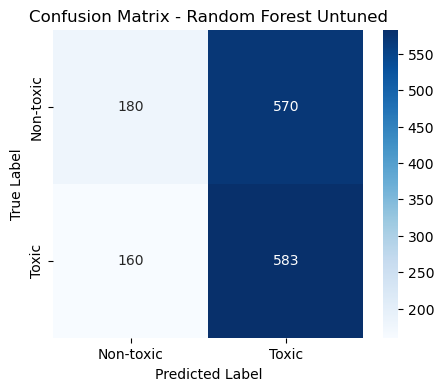

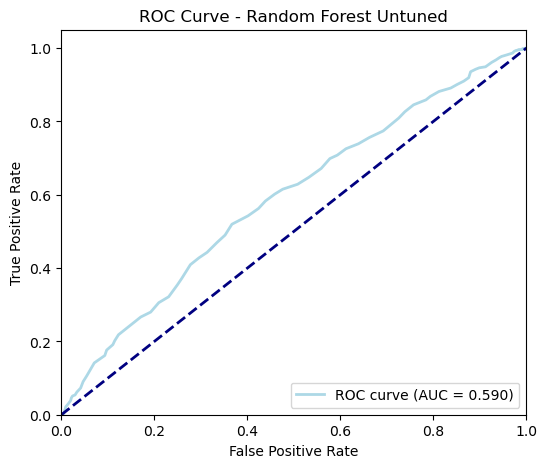

In [144]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    RocCurveDisplay
)

# Binary Accuracy 
#print(f"Binary accuracy: {acc:.3f}")

# Metrics Report
print("\nMetrics Report:")
print(classification_report(y_val, y_pred, target_names=["Non-toxic (0)", "Toxic (1)"]))
cr = classification_report(y_val, y_pred, target_names=class_names, output_dict=True)

acc_comparison = {}
acc_comparison['Random Forest Untuned'] = cr['accuracy']
prec_comparison = {}
prec_comparison['Random Forest Untuned'] = cr['Toxic']['precision']

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Non-toxic", "Toxic"], yticklabels=["Non-toxic", "Toxic"])
plt.title("Confusion Matrix - Random Forest Untuned")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# ROC Curve & AUC
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='lightblue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest Untuned')
plt.legend(loc="lower right")
plt.show()

## Random Forest Tuned

In [68]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import seaborn as sns

# Define the model
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Define parameter search space
param_dist = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 0.3, 0.5],
    'bootstrap': [True, False]
}

# Setup randomized search
search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,           # number of candidate parameter settings
    cv=5,                # 5‑fold cross‐validation
    scoring='accuracy',  # or another metric like 'roc_auc'
    n_jobs=-1,
    random_state=42,
    verbose=2
)

# Fit on your train data
search.fit(X_train, y_train)

print("Best params:", search.best_params_)
best_rf = search.best_estimator_

# Then evaluate on validation set
y_pred_tuned = best_rf.predict(X_val)
y_pred_proba_tuned = best_rf.predict_proba(X_val)[:, 1]
acc_val_tuned = accuracy_score(y_val, y_pred_tuned)
#print(f"Validation accuracy: {acc_val_tuned:.3f}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best params: {'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 0.5, 'max_depth': 10, 'bootstrap': True}



Metrics Report (Tuned Model):
              precision    recall  f1-score   support

       Toxic       0.60      0.56      0.58       750
   Non-Toxic       0.59      0.63      0.61       743

    accuracy                           0.59      1493
   macro avg       0.60      0.59      0.59      1493
weighted avg       0.60      0.59      0.59      1493



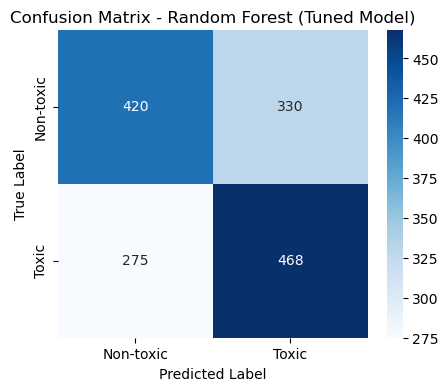

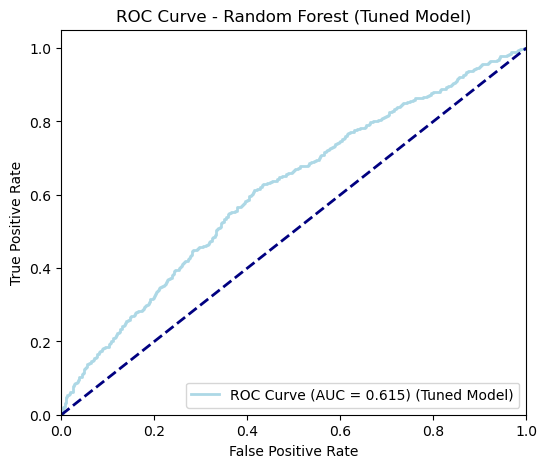

In [145]:
# Metrics Report
print("\nMetrics Report (Tuned Model):")
print(classification_report(y_val, y_pred_tuned, target_names=class_names))
cr = classification_report(y_val, y_pred_tuned, target_names=class_names, output_dict=True)
acc_comparison['Random Forest Tuned'] = cr['accuracy']
prec_comparison['Random Forest Tuned'] = cr['Toxic']['precision']

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred_tuned)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Non-toxic", "Toxic"], yticklabels=["Non-toxic", "Toxic"])
plt.title("Confusion Matrix - Random Forest (Tuned Model)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# ROC Curve & AUC
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba_tuned)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='lightblue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.3f}) (Tuned Model)')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest (Tuned Model)')
plt.legend(loc="lower right")
plt.show()

## Functions for model training/evaluation

In [142]:
# ============================================================================
# Training and Evaluation Functions (Provided - No modifications needed)
# ============================================================================

def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train the model for one epoch."""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(dataloader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() #* inputs.size(0) # added * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc


def evaluate(model, dataloader, criterion, device):
    """Evaluate the model."""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

def metrics(current_model):
    current_model.eval()
    y_true = []
    y_pred = []

    if current_model == model_rand_weights_la:
        name = 'EfficientNetB0, Random Weights, Light Aug'
    elif current_model == model_rand_weights_ha:
        name = 'EfficientNetB0, Random Weights, Heavy Aug'
    elif current_model == model_pretrained_weights_la:
        name = 'EfficientNetB0, Pretrained Weights, Light Aug'
    elif current_model == model_pretrained_weights_ha:
        name = 'EfficientNetB0, Pretrained Weights, Heavy Aug'
    elif current_model == model_cbam_random_la:
        name = 'EfficientNetB0_CBAM, Random Weights, Light Aug'
    elif current_model == model_cbam_random_ha:
        name = 'EfficientNetB0_CBAM, Random Weights, Heavy Aug'
    elif current_model == model_cbam_pretrained_la:
        name = 'EfficientNetB0_CBAM, Pretrained Weights, Light Aug'
    elif current_model == model_cbam_pretrained_ha:
        name = 'EfficientNetB0_CBAM, Pretrained Weights, Heavy Aug'
    else:
        name = 'MODEL NOT NAMED'
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = current_model(images)
            _, predicted = outputs.max(1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    
    # Print classification report
    cr = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    acc_comparison[name] = cr['accuracy']
    prec_comparison[name] = cr['Toxic']['precision']
    print(f"\nClassification Report for {name}':\n")
    print(classification_report(y_true, y_pred, target_names=class_names))
    
    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for {name}')
    plt.show()

    # ROC Curve & AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, color='lightblue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {name}')
    plt.legend(loc="lower right")
    plt.show()


def train_model(model, train_loader, val_loader, num_epochs=10, lr=0.001):
    """
    Train and evaluate a model.

    Returns:
        Dictionary with training history
    """
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 30)

        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

        scheduler.step()

    return history


def plot_training_history(history, title="Training History"):
    """Plot training and validation loss/accuracy."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Val Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title(f'{title} - Loss')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(history['train_acc'], label='Train Acc')
    ax2.plot(history['val_acc'], label='Val Acc')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title(f'{title} - Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

In [29]:
def show_training(model, model_name, train_loader=train_loader, val_loader=val_loader, num_epochs=10):
    # Print number of parameters
    print(f"{model_name}0: {sum(p.numel() for p in model.parameters()):,}")
    
    # Train model using training loader and validate on validation loader
    model_history = train_model(model, train_loader, val_loader, num_epochs=num_epochs)
    
    # Store results
    results = {}
    results[model_name] = model_history['val_acc'][-1]
    
    # Plot results
    plot_training_history(model_history, model_name)

## EfficientNetB0

In [30]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Hyperparameters/Options
batch_size = 32
num_epochs = 10
learning_rate = 1e-4

Using device: cuda


In [31]:
def EffNetB0(pretrained=True):
    # If pretrained is true, use ImageNet for weights, else use random weights
    if pretrained:
        model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
    else:
        model = models.efficientnet_b0(weights=None)
    
    # Freeze base layers
    for param in model.features.parameters():
        param.requires_grad = False
    
    # Replace classifier head
    num_features = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(0.2),
        nn.Linear(num_features, 2)  # binary classification: toxic vs. non-toxic
    )
    
    model = model.to(device)
    return model

### EfficientNetB0, Random Weights, Light Augmentation

EfficientNetB0, Random Weights0: 4,010,110

Epoch 1/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 15.53it/s]


Train Loss: 0.7097, Train Acc: 49.94%
Val Loss: 0.6962, Val Acc: 52.38%

Epoch 2/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:02<00:00, 17.64it/s]


Train Loss: 0.7163, Train Acc: 50.32%
Val Loss: 0.7234, Val Acc: 50.03%

Epoch 3/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:02<00:00, 16.10it/s]


Train Loss: 0.7129, Train Acc: 50.23%
Val Loss: 0.6929, Val Acc: 52.78%

Epoch 4/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:02<00:00, 17.20it/s]


Train Loss: 0.7194, Train Acc: 50.17%
Val Loss: 0.7690, Val Acc: 49.03%

Epoch 5/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:02<00:00, 16.53it/s]


Train Loss: 0.7195, Train Acc: 49.31%
Val Loss: 0.7348, Val Acc: 50.23%

Epoch 6/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:02<00:00, 16.17it/s]


Train Loss: 0.6981, Train Acc: 50.55%
Val Loss: 0.8326, Val Acc: 50.44%

Epoch 7/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:02<00:00, 16.94it/s]


Train Loss: 0.6977, Train Acc: 51.23%
Val Loss: 0.7238, Val Acc: 49.63%

Epoch 8/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:02<00:00, 17.20it/s]


Train Loss: 0.7029, Train Acc: 50.27%
Val Loss: 0.7492, Val Acc: 49.97%

Epoch 9/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:02<00:00, 16.53it/s]


Train Loss: 0.6966, Train Acc: 50.75%
Val Loss: 0.7307, Val Acc: 50.10%

Epoch 10/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:02<00:00, 17.54it/s]


Train Loss: 0.7028, Train Acc: 50.62%
Val Loss: 0.7069, Val Acc: 49.50%


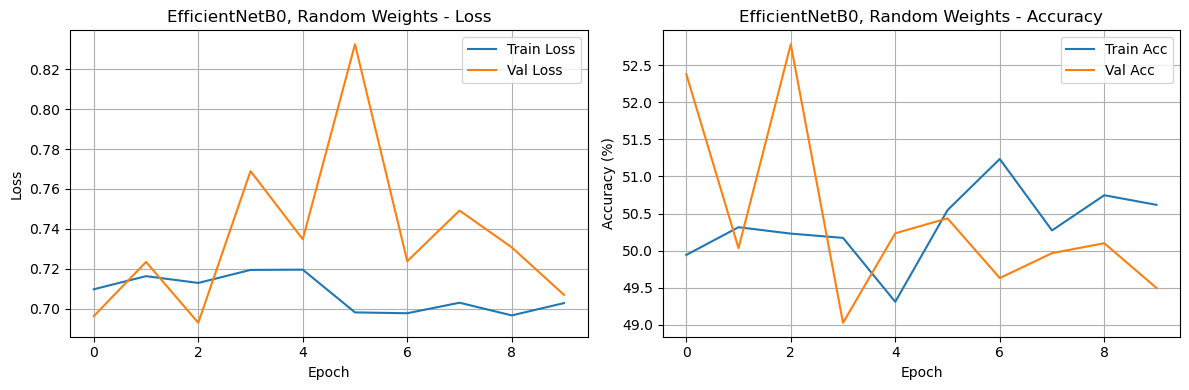

In [32]:
model_rand_weights_la = EffNetB0(pretrained=False)
show_training(model_rand_weights_la, 'EfficientNetB0, Random Weights')

#### Evaluation


Classification Report for EfficientNetB0, Random Weights, Light Aug':

              precision    recall  f1-score   support

       Toxic       0.53      0.24      0.33       749
   Non-Toxic       0.51      0.78      0.62       744

    accuracy                           0.51      1493
   macro avg       0.52      0.51      0.47      1493
weighted avg       0.52      0.51      0.47      1493



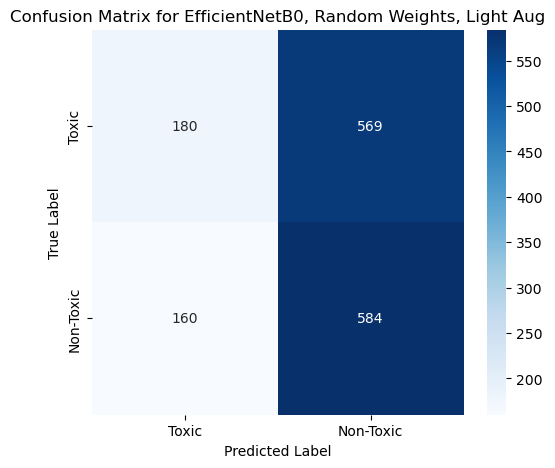

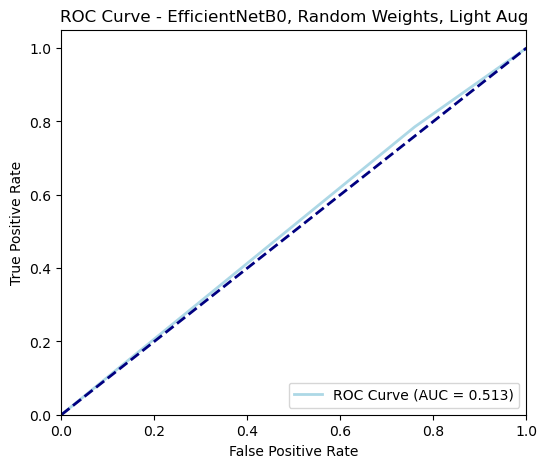

In [146]:
metrics(model_rand_weights_la)

### EfficientNetB0, Random Weights, Heavy Augmentation

EfficientNetB0, Random Weights, Strong Aug0: 4,010,110

Epoch 1/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:02<00:00, 17.06it/s]


Train Loss: 0.7110, Train Acc: 50.34%
Val Loss: 0.7262, Val Acc: 48.29%

Epoch 2/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:02<00:00, 16.68it/s]


Train Loss: 0.7035, Train Acc: 51.05%
Val Loss: 0.7160, Val Acc: 49.97%

Epoch 3/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:02<00:00, 17.10it/s]


Train Loss: 0.7180, Train Acc: 51.15%
Val Loss: 0.7172, Val Acc: 50.84%

Epoch 4/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:02<00:00, 17.40it/s]


Train Loss: 0.7252, Train Acc: 50.90%
Val Loss: 0.7262, Val Acc: 51.11%

Epoch 5/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:02<00:00, 17.36it/s]


Train Loss: 0.7110, Train Acc: 51.48%
Val Loss: 0.7135, Val Acc: 50.64%

Epoch 6/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:02<00:00, 17.88it/s]


Train Loss: 0.6969, Train Acc: 52.66%
Val Loss: 0.6970, Val Acc: 51.17%

Epoch 7/10
------------------------------


Evaluating:  40%|████      | 19/47 [00:01<00:01, 17.93it/s]

[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=30, max_features=0.5, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   2.1s
[CV] END bootstrap=True, max_depth=40, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   1.7s
[CV] END bootstrap=True, max_depth=40, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   1.2s
[CV] END bootstrap=False, max_depth=40, max_features=0.3, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   7.8s
[CV] END bootstrap=False, max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   9.1s
[CV] END bootstrap=True, max_depth=None, max_features=0.5, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   9.0s
[CV] END bootstrap=True, max_depth=None, max

Evaluating:  74%|███████▍  | 35/47 [00:02<00:00, 18.36it/s]

[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   1.5s
[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   2.5s
[CV] END bootstrap=False, max_depth=10, max_features=0.3, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.9s
[CV] END bootstrap=False, max_depth=40, max_features=0.3, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   4.8s
[CV] END bootstrap=False, max_depth=40, max_features=0.5, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   5.9s
[CV] END bootstrap=True, max_depth=10, max_features=0.3, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   1.6s
[CV] END bootstrap=True, max_depth=10, max_fea

Evaluating:  96%|█████████▌| 45/47 [00:02<00:00, 18.52it/s]

[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.0s
[CV] END bootstrap=True, max_depth=30, max_features=0.5, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   2.5s
[CV] END bootstrap=False, max_depth=10, max_features=0.3, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   1.1s
[CV] END bootstrap=False, max_depth=40, max_features=0.5, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=  10.0s
[CV] END bootstrap=True, max_depth=10, max_features=0.3, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   1.8s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   4.2s
[CV] END bootstrap=True, max_depth=None, max_fe

Evaluating: 100%|██████████| 47/47 [00:02<00:00, 16.01it/s]


Train Loss: 0.6973, Train Acc: 51.56%
Val Loss: 0.6990, Val Acc: 50.64%

Epoch 8/10
------------------------------


Training:   3%|▎         | 7/218 [00:00<00:16, 13.18it/s]

[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   2.1s
[CV] END bootstrap=True, max_depth=30, max_features=0.5, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   1.4s
[CV] END bootstrap=True, max_depth=40, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   1.5s
[CV] END bootstrap=False, max_depth=10, max_features=0.3, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   1.4s
[CV] END bootstrap=False, max_depth=40, max_features=0.5, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   9.0s
[CV] END bootstrap=False, max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   7.9s
[CV] END bootstrap=False, max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=   7.3s
[CV] END bootstrap=False, max_depth=10, max_

Training:  11%|█         | 23/218 [00:01<00:10, 18.66it/s]

[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   2.6s
[CV] END bootstrap=True, max_depth=40, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   1.0s
[CV] END bootstrap=False, max_depth=40, max_features=0.3, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   3.5s
[CV] END bootstrap=False, max_depth=40, max_features=0.5, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   5.1s
[CV] END bootstrap=False, max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   3.7s
[CV] END bootstrap=True, max_depth=10, max_features=0.3, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=40, max_f

Training:  16%|█▌        | 35/218 [00:02<00:09, 19.02it/s]

[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=30, max_features=0.5, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   2.9s
[CV] END bootstrap=False, max_depth=40, max_features=0.3, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   8.3s
[CV] END bootstrap=False, max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   9.3s
[CV] END bootstrap=False, max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=   8.7s
[CV] END bootstrap=True, max_depth=None, max_features=0.5, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   3.4s
[CV] END bootstrap=True, max_depth=40, 

Training:  23%|██▎       | 51/218 [00:03<00:08, 18.73it/s]

[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   2.4s
[CV] END bootstrap=True, max_depth=40, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   1.9s
[CV] END bootstrap=False, max_depth=10, max_features=0.3, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   1.6s
[CV] END bootstrap=False, max_depth=40, max_features=0.5, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=  10.1s
[CV] END bootstrap=True, max_depth=10, max_features=0.3, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   1.4s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   2.8s
[CV] END bootstrap=True, max_depth=None, max_feat

Training:  28%|██▊       | 61/218 [00:03<00:11, 14.13it/s]

[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   1.8s
[CV] END bootstrap=True, max_depth=30, max_features=0.5, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   2.1s
[CV] END bootstrap=False, max_depth=10, max_features=0.3, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   1.0s
[CV] END bootstrap=False, max_depth=40, max_features=0.3, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   7.6s
[CV] END bootstrap=False, max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   8.8s
[CV] END bootstrap=True, max_depth=None, max_features=0.5, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   7.6s
[CV] END bootstrap=False, max_depth=10, ma

Evaluating: 100%|██████████| 47/47 [00:03<00:00, 14.85it/s]


Train Loss: 0.7004, Train Acc: 51.95%
Val Loss: 0.7023, Val Acc: 51.37%

Epoch 9/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 15.29it/s]


Train Loss: 0.6995, Train Acc: 51.56%
Val Loss: 0.6944, Val Acc: 51.24%

Epoch 10/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:02<00:00, 15.72it/s]


Train Loss: 0.6991, Train Acc: 51.48%
Val Loss: 0.7066, Val Acc: 50.30%


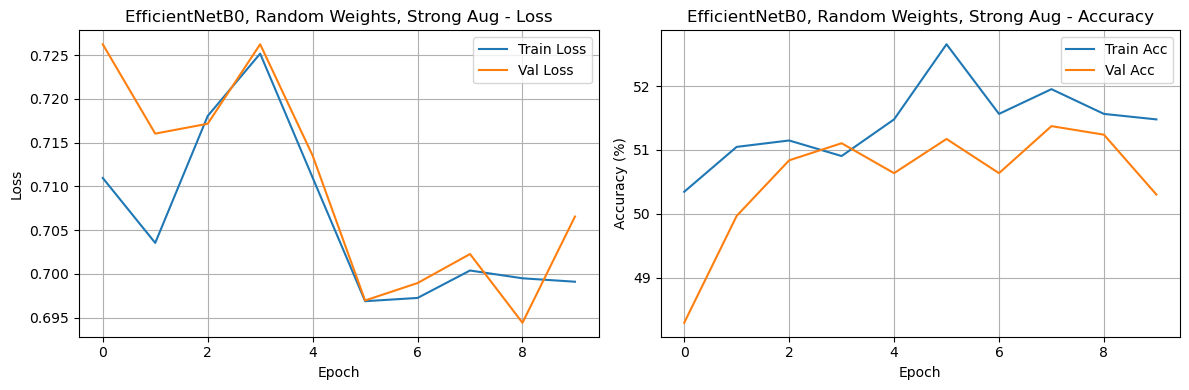

In [35]:
model_rand_weights_ha = EffNetB0(pretrained=False)
show_training(model_rand_weights_ha, 'EfficientNetB0, Random Weights, Strong Aug', train_loader = train_strong_loader)

#### Evaluation


Classification Report for EfficientNetB0, Random Weights, Heavy Aug':

              precision    recall  f1-score   support

       Toxic       0.52      0.76      0.62       749
   Non-Toxic       0.55      0.30      0.38       744

    accuracy                           0.53      1493
   macro avg       0.53      0.53      0.50      1493
weighted avg       0.53      0.53      0.50      1493



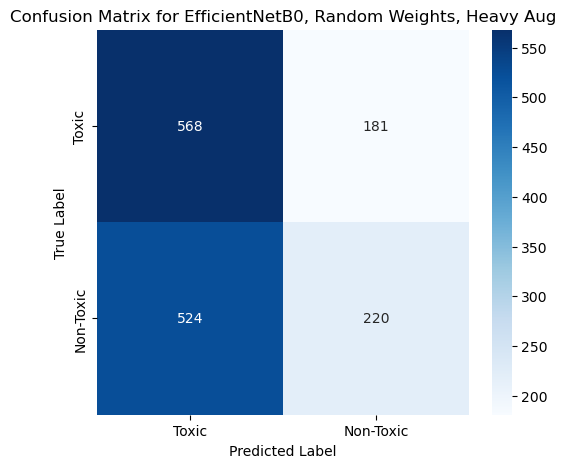

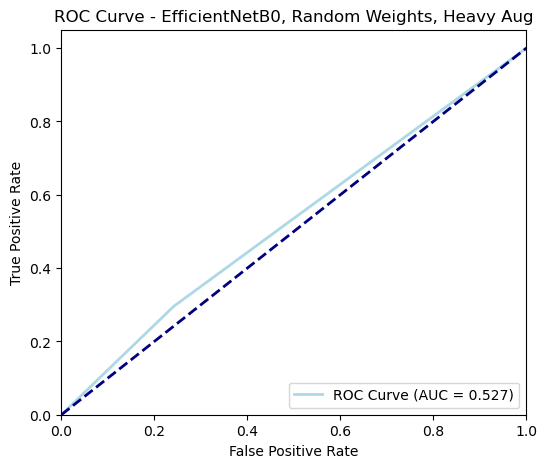

In [147]:
metrics(model_rand_weights_ha)

### EfficientNetB0 Model, ImageNet Weights, Light Augmentation

EfficientNetB0, Pretrained Weights, Light Aug0: 4,010,110

Epoch 1/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:02<00:00, 16.27it/s]


Train Loss: 0.6747, Train Acc: 58.21%
Val Loss: 0.6393, Val Acc: 63.03%

Epoch 2/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:02<00:00, 16.49it/s]


Train Loss: 0.6417, Train Acc: 62.58%
Val Loss: 0.6303, Val Acc: 64.63%

Epoch 3/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:02<00:00, 17.14it/s]


Train Loss: 0.6339, Train Acc: 64.67%
Val Loss: 0.6235, Val Acc: 64.30%

Epoch 4/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:02<00:00, 16.10it/s]


Train Loss: 0.6234, Train Acc: 65.25%
Val Loss: 0.6305, Val Acc: 65.57%

Epoch 5/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:02<00:00, 16.41it/s]


Train Loss: 0.6191, Train Acc: 65.37%
Val Loss: 0.6193, Val Acc: 65.57%

Epoch 6/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:02<00:00, 16.83it/s]


Train Loss: 0.6044, Train Acc: 67.21%
Val Loss: 0.6131, Val Acc: 66.24%

Epoch 7/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:02<00:00, 16.61it/s]


Train Loss: 0.6069, Train Acc: 66.48%
Val Loss: 0.6174, Val Acc: 65.44%

Epoch 8/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:02<00:00, 16.09it/s]


Train Loss: 0.6075, Train Acc: 66.97%
Val Loss: 0.6132, Val Acc: 66.51%

Epoch 9/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:02<00:00, 17.24it/s]


Train Loss: 0.6077, Train Acc: 66.64%
Val Loss: 0.6173, Val Acc: 66.38%

Epoch 10/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:02<00:00, 17.55it/s]


Train Loss: 0.6055, Train Acc: 67.30%
Val Loss: 0.6125, Val Acc: 66.11%


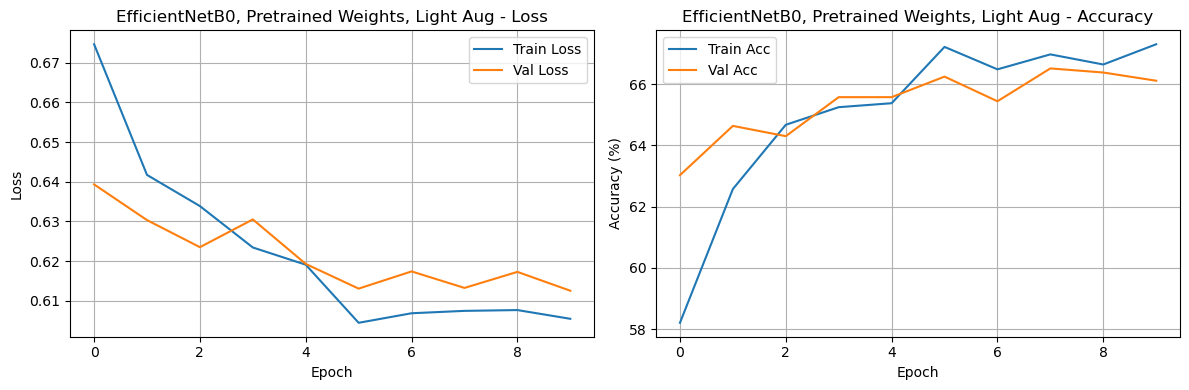

In [38]:
model_pretrained_weights_la = EffNetB0(pretrained=True)
show_training(model_pretrained_weights_la, 'EfficientNetB0, Pretrained Weights, Light Aug')

#### Evaluation


Classification Report for EfficientNetB0, Pretrained Weights, Light Aug':

              precision    recall  f1-score   support

       Toxic       0.65      0.68      0.67       749
   Non-Toxic       0.67      0.63      0.65       744

    accuracy                           0.66      1493
   macro avg       0.66      0.66      0.66      1493
weighted avg       0.66      0.66      0.66      1493



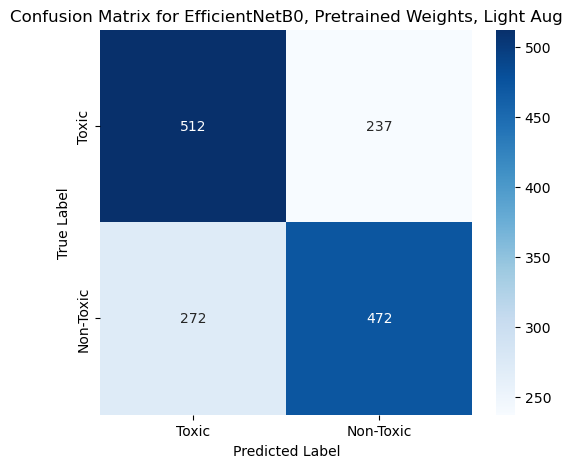

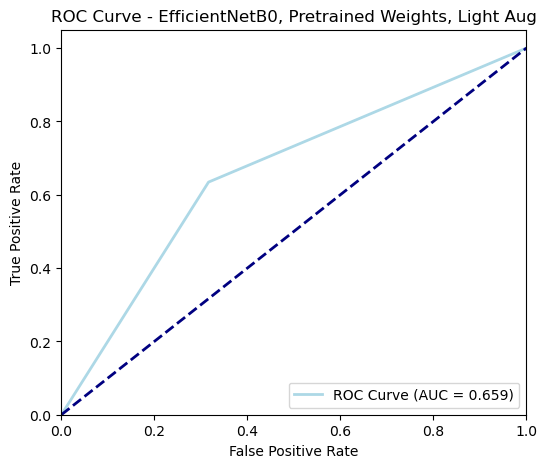

In [148]:
metrics(model_pretrained_weights_la)

### EfficientNetB0 Model, ImageNet Weights, Heavy Augmentation

EfficientNetB0, Pretrained Weights, Heavy Aug0: 4,010,110

Epoch 1/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:02<00:00, 16.85it/s]


Train Loss: 0.6693, Train Acc: 58.53%
Val Loss: 0.6355, Val Acc: 62.83%

Epoch 2/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:02<00:00, 17.08it/s]


Train Loss: 0.6415, Train Acc: 63.06%
Val Loss: 0.6353, Val Acc: 63.83%

Epoch 3/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:02<00:00, 16.32it/s]


Train Loss: 0.6346, Train Acc: 63.81%
Val Loss: 0.6336, Val Acc: 64.37%

Epoch 4/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:02<00:00, 16.57it/s]


Train Loss: 0.6370, Train Acc: 64.33%
Val Loss: 0.6249, Val Acc: 65.44%

Epoch 5/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:02<00:00, 17.28it/s]


Train Loss: 0.6201, Train Acc: 65.56%
Val Loss: 0.6377, Val Acc: 63.30%

Epoch 6/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:02<00:00, 16.53it/s]


Train Loss: 0.6146, Train Acc: 66.62%
Val Loss: 0.6238, Val Acc: 65.30%

Epoch 7/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:02<00:00, 16.92it/s]


Train Loss: 0.6098, Train Acc: 65.91%
Val Loss: 0.6207, Val Acc: 65.24%

Epoch 8/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:02<00:00, 16.69it/s]


Train Loss: 0.6098, Train Acc: 66.84%
Val Loss: 0.6215, Val Acc: 65.04%

Epoch 9/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:02<00:00, 16.38it/s]


Train Loss: 0.6082, Train Acc: 66.85%
Val Loss: 0.6210, Val Acc: 65.10%

Epoch 10/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:02<00:00, 16.65it/s]


Train Loss: 0.6105, Train Acc: 66.42%
Val Loss: 0.6160, Val Acc: 66.38%


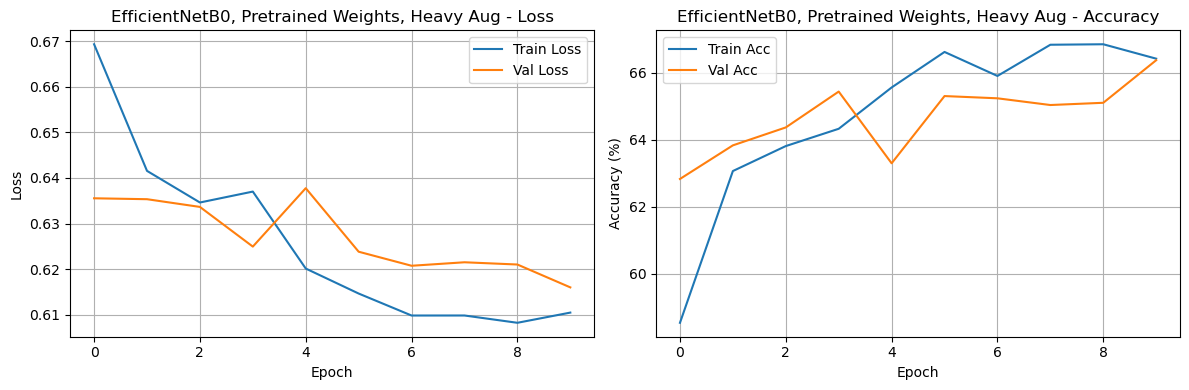

In [40]:
model_pretrained_weights_ha = EffNetB0(pretrained=True)
show_training(model_pretrained_weights_ha, 'EfficientNetB0, Pretrained Weights, Heavy Aug', train_loader = train_strong_loader)

#### Evaluation


Classification Report for EfficientNetB0, Pretrained Weights, Heavy Aug':

              precision    recall  f1-score   support

       Toxic       0.67      0.67      0.67       749
   Non-Toxic       0.66      0.66      0.66       744

    accuracy                           0.67      1493
   macro avg       0.67      0.67      0.67      1493
weighted avg       0.67      0.67      0.67      1493



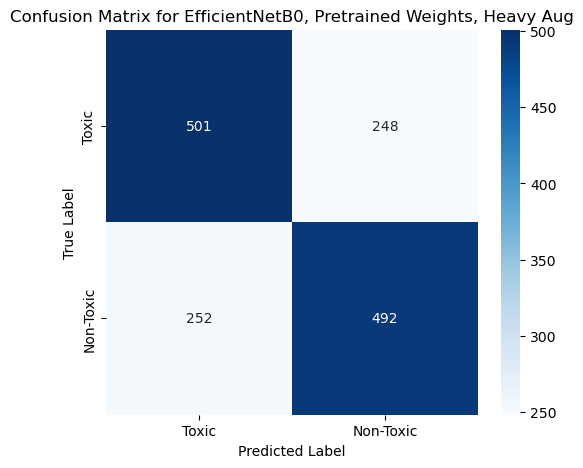

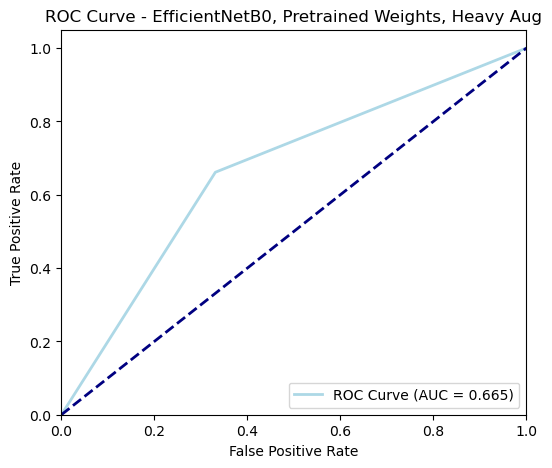

In [149]:
metrics(model_pretrained_weights_ha)

## CBAM (Convolutional Block Attention Module)

Sequential channel attention and spatial attention.

In [42]:
# Channel attention module
class CAM(nn.Module):
  def __init__(self, channels, r):
    super(CAM, self).__init__()
    self.mlp = nn.Sequential(
        nn.Linear(channels, channels // r, bias=False),
        nn.ReLU(inplace=True),
        nn.Linear(channels // r, channels, bias=False)
    )
    self.sigmoid = nn.Sigmoid()
  
  def forward(self, x):
    b, c, h, w = x.size()
    avg_pool = F.adaptive_avg_pool2d(x, 1).view(b, c)
    max_pool = F.adaptive_max_pool2d(x, 1).view(b, c)
    attn = self.mlp(avg_pool) + self.mlp(max_pool)
    attn = self.sigmoid(attn).view(b, c, 1, 1)
    return attn * x

# Spatial attention module
class SAM(nn.Module):
  def __init__(self, kernel_size=7, bias=False):
    super(SAM, self).__init__()
    self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=bias)
    self.sigmoid = nn.Sigmoid()
  
  def forward(self, x):
    avg_out = torch.mean(x, dim=1, keepdim=True)
    max_out, _ = torch.max(x, dim=1, keepdim=True)
    x_cat = torch.cat([avg_out, max_out], dim=1)
    x_out = self.conv(x_cat)
    attn = self.sigmoid(x_out)
    return attn * x

# CBAM
class CBAM(nn.Module):
  def __init__(self, channels, r=16):
    super(CBAM, self).__init__()
    self.channels = channels
    self.r = r
    self.cam = CAM(channels, r)
    self.sam = SAM(bias=False)

  def forward(self, x):
    output = self.cam(x)
    output = self.sam(output)
    return output

In [43]:
# Implement CBAM before last classifier in EfficientNetB0
class EfficientNetB0_CBAM(nn.Module):
    def __init__(self, num_classes=2, pretrained=True):
        super(EfficientNetB0_CBAM, self).__init__()
        if pretrained:
            base_model = models.efficientnet_b0(weights='EfficientNet_B0_Weights.DEFAULT')
        else:
            base_model = models.efficientnet_b0(weights=None)
        
        self.features = base_model.features
        self.cbam = CBAM(channels=1280)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Linear(in_features=1280, out_features=num_classes)
        
    def forward(self, x):
      x = self.features(x)
      x = self.cbam(x)
      x = self.pool(x).flatten(1)
      x = self.classifier(x)
      return x

### EfficientNetB0_CBAM, Random Weights, Light Augmentation

EfficientNetB0_CBAM, Random Meights, Light Aug0: 4,215,008

Epoch 1/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:02<00:00, 15.94it/s]


Train Loss: 0.6954, Train Acc: 52.45%
Val Loss: 0.6967, Val Acc: 51.51%

Epoch 2/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:02<00:00, 17.13it/s]


Train Loss: 0.6903, Train Acc: 53.82%
Val Loss: 0.6874, Val Acc: 55.32%

Epoch 3/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 15.29it/s]


Train Loss: 0.6917, Train Acc: 52.24%
Val Loss: 0.6900, Val Acc: 54.45%

Epoch 4/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:02<00:00, 16.72it/s]


Train Loss: 0.6890, Train Acc: 55.12%
Val Loss: 0.6814, Val Acc: 57.60%

Epoch 5/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:02<00:00, 16.72it/s]


Train Loss: 0.6839, Train Acc: 56.13%
Val Loss: 0.6795, Val Acc: 55.73%

Epoch 6/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:02<00:00, 16.93it/s]


Train Loss: 0.6777, Train Acc: 57.26%
Val Loss: 0.6662, Val Acc: 56.93%

Epoch 7/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:02<00:00, 16.70it/s]


Train Loss: 0.6695, Train Acc: 58.50%
Val Loss: 0.6608, Val Acc: 59.41%

Epoch 8/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:02<00:00, 16.13it/s]


Train Loss: 0.6612, Train Acc: 59.20%
Val Loss: 0.6617, Val Acc: 60.21%

Epoch 9/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:02<00:00, 16.37it/s]


Train Loss: 0.6580, Train Acc: 60.91%
Val Loss: 0.6635, Val Acc: 59.61%

Epoch 10/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 15.65it/s]


Train Loss: 0.6493, Train Acc: 61.10%
Val Loss: 0.6663, Val Acc: 59.28%


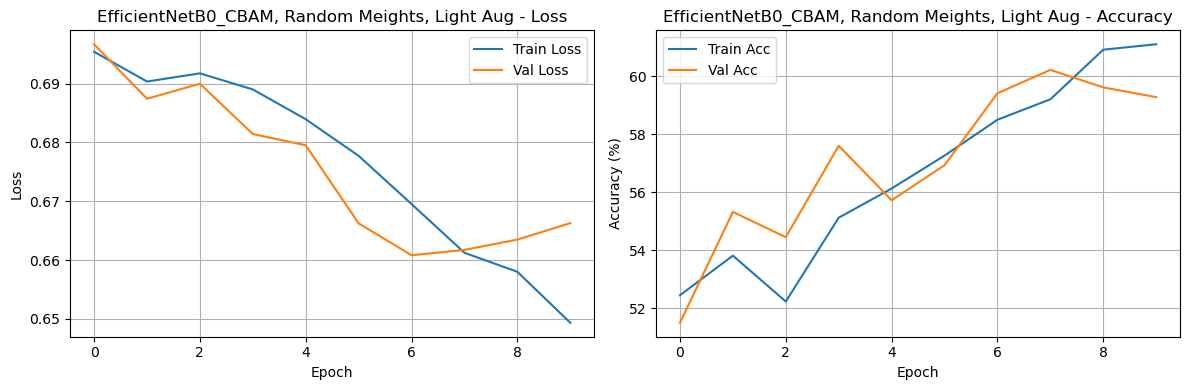

In [45]:
model_cbam_random_la = EfficientNetB0_CBAM(num_classes=2, pretrained=False)
show_training(model_cbam_random_la, 'EfficientNetB0_CBAM, Random Meights, Light Aug')

#### Evaluation


Classification Report for EfficientNetB0_CBAM, Random Weights, Light Aug':

              precision    recall  f1-score   support

       Toxic       0.59      0.58      0.58       749
   Non-Toxic       0.58      0.59      0.59       744

    accuracy                           0.59      1493
   macro avg       0.59      0.59      0.59      1493
weighted avg       0.59      0.59      0.59      1493



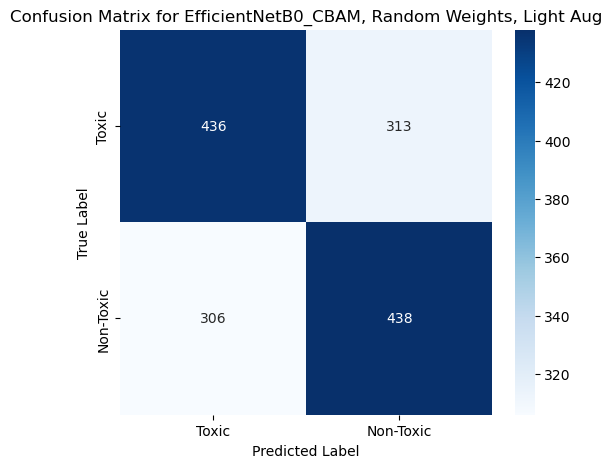

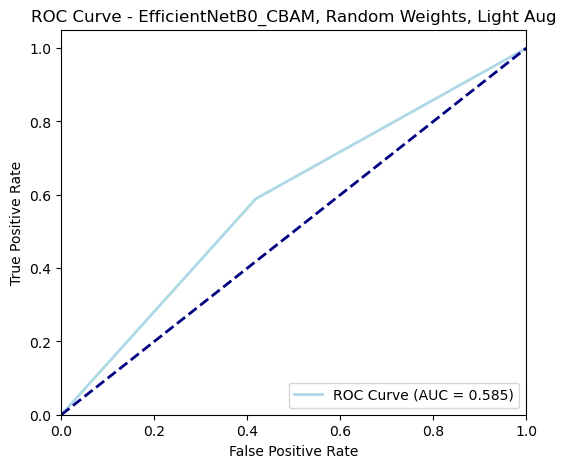

In [150]:
metrics(model_cbam_random_la)

### EfficientNetB0_CBAM, Random Weights, Heavy Augmentation

EfficientNetB0_CBAM, Random Weights, Heavy Aug0: 4,215,008

Epoch 1/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:02<00:00, 16.65it/s]


Train Loss: 0.6968, Train Acc: 51.55%
Val Loss: 0.6984, Val Acc: 52.51%

Epoch 2/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:02<00:00, 16.38it/s]


Train Loss: 0.6931, Train Acc: 51.22%
Val Loss: 0.6930, Val Acc: 49.90%

Epoch 3/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:02<00:00, 16.36it/s]


Train Loss: 0.6932, Train Acc: 50.04%
Val Loss: 0.6943, Val Acc: 49.56%

Epoch 4/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:02<00:00, 16.65it/s]


Train Loss: 0.6932, Train Acc: 50.40%
Val Loss: 0.6933, Val Acc: 49.83%

Epoch 5/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:02<00:00, 16.45it/s]


Train Loss: 0.6931, Train Acc: 51.03%
Val Loss: 0.6924, Val Acc: 51.91%

Epoch 6/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:02<00:00, 16.31it/s]


Train Loss: 0.6921, Train Acc: 52.18%
Val Loss: 0.6924, Val Acc: 51.11%

Epoch 7/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:02<00:00, 16.52it/s]


Train Loss: 0.6909, Train Acc: 53.63%
Val Loss: 0.6926, Val Acc: 51.37%

Epoch 8/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:02<00:00, 16.87it/s]


Train Loss: 0.6878, Train Acc: 54.45%
Val Loss: 0.6895, Val Acc: 54.25%

Epoch 9/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:02<00:00, 16.51it/s]


Train Loss: 0.6868, Train Acc: 55.24%
Val Loss: 0.6804, Val Acc: 56.40%

Epoch 10/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:02<00:00, 16.43it/s]


Train Loss: 0.6814, Train Acc: 56.70%
Val Loss: 0.6694, Val Acc: 58.14%


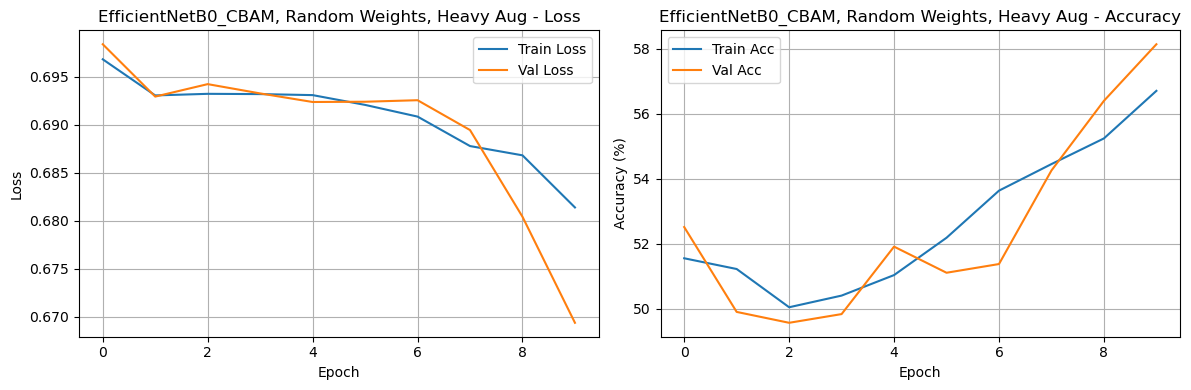

In [47]:
model_cbam_random_ha = EfficientNetB0_CBAM(num_classes=2, pretrained=False)
show_training(model_cbam_random_ha, 'EfficientNetB0_CBAM, Random Weights, Heavy Aug', train_loader = train_strong_loader)

#### Evaluation


Classification Report for EfficientNetB0_CBAM, Random Weights, Heavy Aug':

              precision    recall  f1-score   support

       Toxic       0.55      0.59      0.57       749
   Non-Toxic       0.55      0.51      0.53       744

    accuracy                           0.55      1493
   macro avg       0.55      0.55      0.55      1493
weighted avg       0.55      0.55      0.55      1493



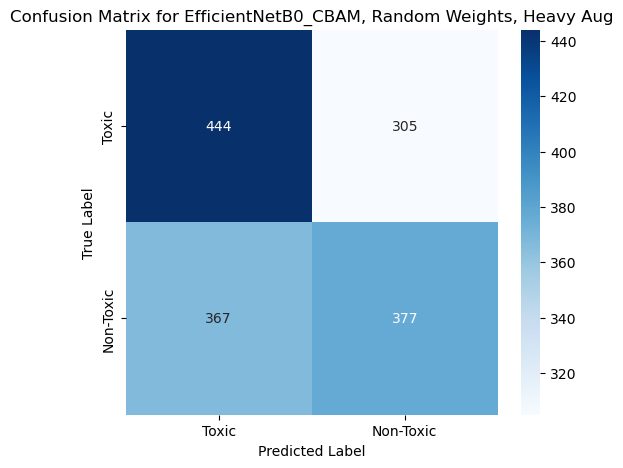

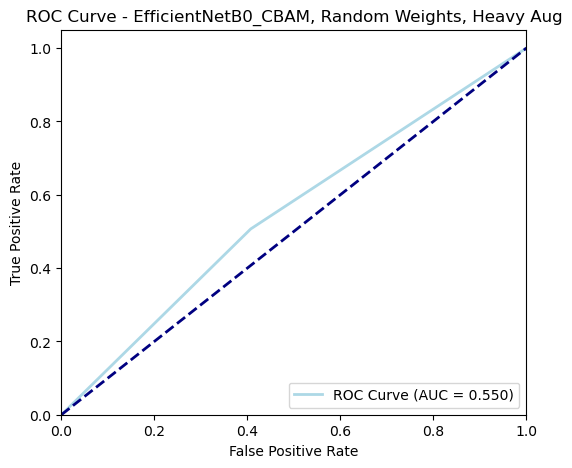

In [151]:
metrics(model_cbam_random_ha)

### EfficientNetB0_CBAM, ImageNet Weights, Light Augmentation

EfficientNetB0_CBAM, Pretrained Weights0: 4,215,008

Epoch 1/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:02<00:00, 16.04it/s]


Train Loss: 0.6052, Train Acc: 65.98%
Val Loss: 0.5669, Val Acc: 68.52%

Epoch 2/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:02<00:00, 17.03it/s]


Train Loss: 0.4896, Train Acc: 76.60%
Val Loss: 0.5072, Val Acc: 75.42%

Epoch 3/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:02<00:00, 16.22it/s]


Train Loss: 0.3797, Train Acc: 82.99%
Val Loss: 0.4937, Val Acc: 77.83%

Epoch 4/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:02<00:00, 16.40it/s]


Train Loss: 0.3044, Train Acc: 86.97%
Val Loss: 0.5314, Val Acc: 77.36%

Epoch 5/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:02<00:00, 16.81it/s]


Train Loss: 0.2281, Train Acc: 90.65%
Val Loss: 0.4373, Val Acc: 80.31%

Epoch 6/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 15.59it/s]


Train Loss: 0.1126, Train Acc: 95.87%
Val Loss: 0.5147, Val Acc: 83.12%

Epoch 7/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:02<00:00, 16.57it/s]


Train Loss: 0.0529, Train Acc: 98.21%
Val Loss: 0.6068, Val Acc: 83.66%

Epoch 8/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:02<00:00, 16.06it/s]


Train Loss: 0.0373, Train Acc: 98.74%
Val Loss: 0.6523, Val Acc: 84.46%

Epoch 9/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:02<00:00, 16.23it/s]


Train Loss: 0.0321, Train Acc: 98.79%
Val Loss: 0.7148, Val Acc: 83.05%

Epoch 10/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 14.97it/s]


Train Loss: 0.0195, Train Acc: 99.37%
Val Loss: 0.7526, Val Acc: 82.92%


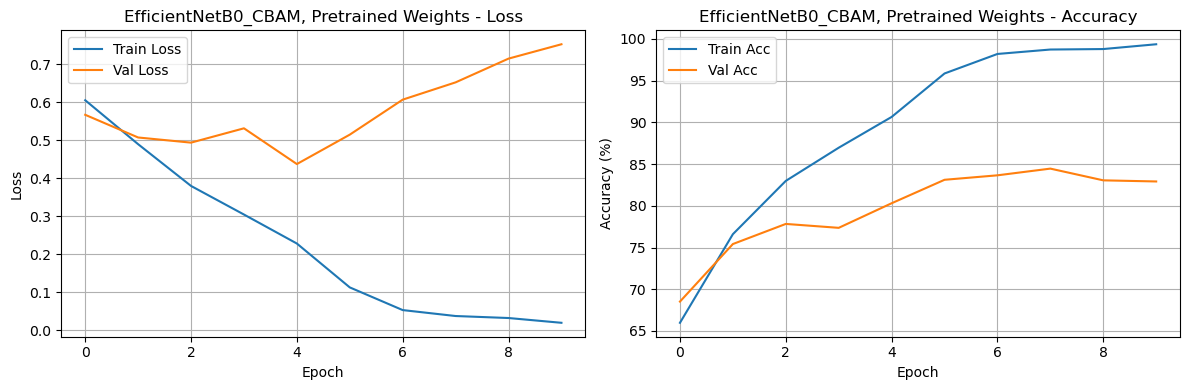

In [49]:
model_cbam_pretrained_la = EfficientNetB0_CBAM(num_classes=2, pretrained=True)
show_training(model_cbam_pretrained_la, 'EfficientNetB0_CBAM, Pretrained Weights')

#### Evaluation


Classification Report for EfficientNetB0_CBAM, Pretrained Weights, Light Aug':

              precision    recall  f1-score   support

       Toxic       0.82      0.81      0.82       749
   Non-Toxic       0.81      0.82      0.82       744

    accuracy                           0.82      1493
   macro avg       0.82      0.82      0.82      1493
weighted avg       0.82      0.82      0.82      1493



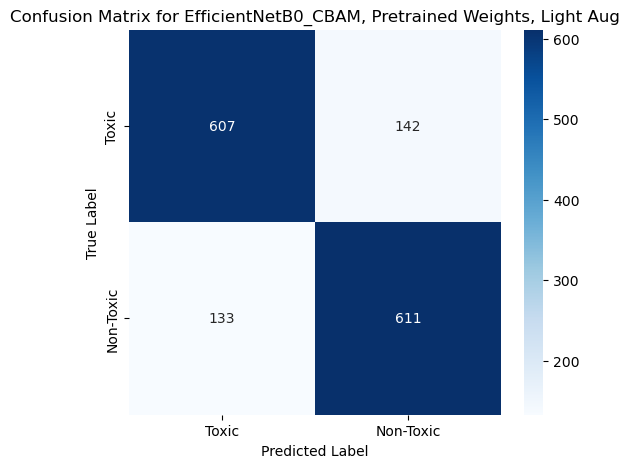

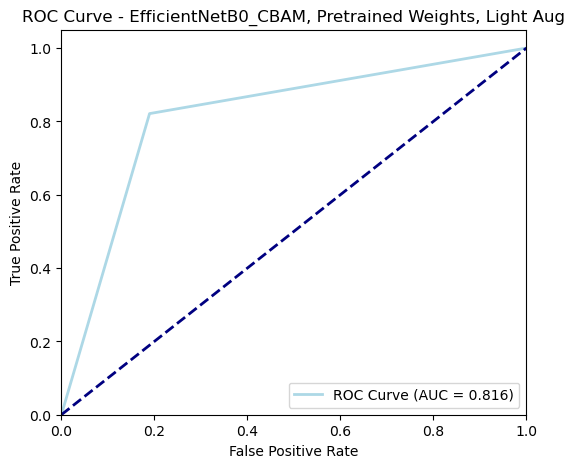

In [152]:
metrics(model_cbam_pretrained_la)

### EfficientNetB0_CBAM, ImageNet Weights, Heavy Augmentation

EfficientNetB0_CBAM, Pretrained Weights0: 4,215,008

Epoch 1/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.76it/s]


Train Loss: 0.5808, Train Acc: 68.55%
Val Loss: 0.5388, Val Acc: 75.08%

Epoch 2/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:02<00:00, 16.51it/s]


Train Loss: 0.4543, Train Acc: 78.54%
Val Loss: 0.4971, Val Acc: 75.89%

Epoch 3/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:02<00:00, 16.88it/s]


Train Loss: 0.3562, Train Acc: 84.60%
Val Loss: 0.4618, Val Acc: 80.44%

Epoch 4/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 15.65it/s]


Train Loss: 0.2738, Train Acc: 88.36%
Val Loss: 0.5027, Val Acc: 79.91%

Epoch 5/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:02<00:00, 16.04it/s]


Train Loss: 0.2227, Train Acc: 91.04%
Val Loss: 0.5021, Val Acc: 79.84%

Epoch 6/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:02<00:00, 17.50it/s]


Train Loss: 0.1045, Train Acc: 96.34%
Val Loss: 0.5077, Val Acc: 83.26%

Epoch 7/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:02<00:00, 16.60it/s]


Train Loss: 0.0592, Train Acc: 97.90%
Val Loss: 0.5545, Val Acc: 83.86%

Epoch 8/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 15.64it/s]


Train Loss: 0.0395, Train Acc: 98.69%
Val Loss: 0.6074, Val Acc: 83.12%

Epoch 9/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:02<00:00, 17.13it/s]


Train Loss: 0.0276, Train Acc: 99.15%
Val Loss: 0.6452, Val Acc: 83.66%

Epoch 10/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:02<00:00, 16.93it/s]


Train Loss: 0.0217, Train Acc: 99.30%
Val Loss: 0.6851, Val Acc: 83.72%


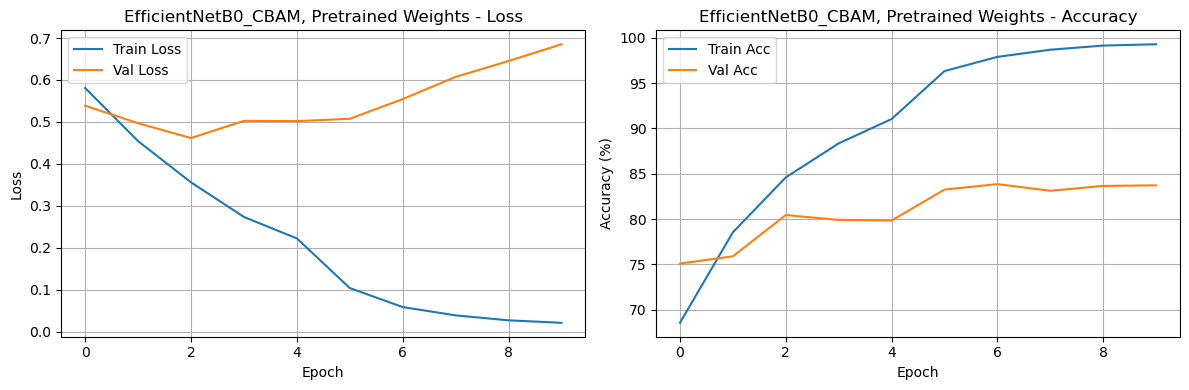

In [51]:
model_cbam_pretrained_ha = EfficientNetB0_CBAM(num_classes=2, pretrained=True)
show_training(model_cbam_pretrained_ha, 'EfficientNetB0_CBAM, Pretrained Weights', train_loader=train_strong_loader)

### Evaluation


Classification Report for EfficientNetB0_CBAM, Pretrained Weights, Heavy Aug':

              precision    recall  f1-score   support

       Toxic       0.82      0.83      0.82       749
   Non-Toxic       0.82      0.82      0.82       744

    accuracy                           0.82      1493
   macro avg       0.82      0.82      0.82      1493
weighted avg       0.82      0.82      0.82      1493



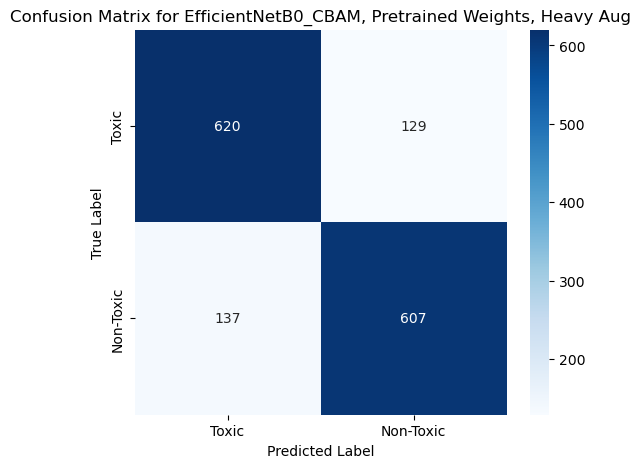

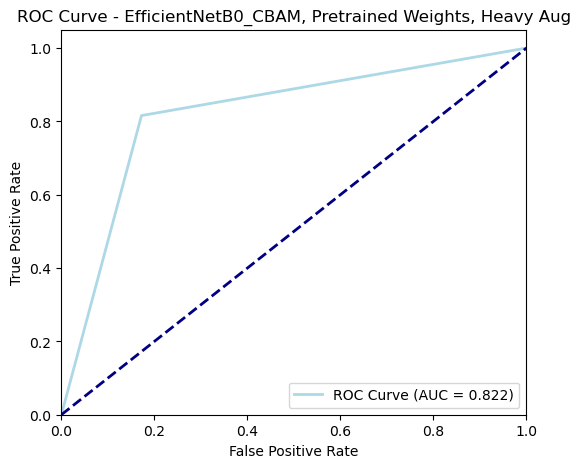

In [153]:
metrics(model_cbam_pretrained_ha)

In [154]:
acc_df = pd.DataFrame.from_dict(acc_comparison, orient='index')
acc_df.columns = ['Accuracy']
print(acc_df.to_string(justify='left'))

                                                    Accuracy
Random Forest Untuned                               0.511052
Random Forest Tuned                                 0.594776
EfficientNetB0, Random Weights, Light Aug           0.511721
EfficientNetB0, Random Weights, Heavy Aug           0.527796
EfficientNetB0, Pretrained Weights, Light Aug       0.659076
EfficientNetB0, Pretrained Weights, Heavy Aug       0.665104
EfficientNetB0_CBAM, Random Weights, Light Aug      0.585399
EfficientNetB0_CBAM, Random Weights, Heavy Aug      0.549900
EfficientNetB0_CBAM, Pretrained Weights, Light Aug  0.815807
EfficientNetB0_CBAM, Pretrained Weights, Heavy Aug  0.821835


In [155]:
prec_df = pd.DataFrame.from_dict(prec_comparison, orient='index')
prec_df.columns = ['Precision']
print(prec_df.to_string(justify='left'))

                                                    Precision
Random Forest Untuned                               0.529412 
Random Forest Tuned                                 0.604317 
EfficientNetB0, Random Weights, Light Aug           0.529412 
EfficientNetB0, Random Weights, Heavy Aug           0.520147 
EfficientNetB0, Pretrained Weights, Light Aug       0.653061 
EfficientNetB0, Pretrained Weights, Heavy Aug       0.665339 
EfficientNetB0_CBAM, Random Weights, Light Aug      0.587601 
EfficientNetB0_CBAM, Random Weights, Heavy Aug      0.547472 
EfficientNetB0_CBAM, Pretrained Weights, Light Aug  0.820270 
EfficientNetB0_CBAM, Pretrained Weights, Heavy Aug  0.819022 


In [156]:
acc_prec = acc_df.join(prec_df, how='left')
print(acc_prec.to_string(justify='left'))

                                                    Accuracy  Precision
Random Forest Untuned                               0.511052  0.529412 
Random Forest Tuned                                 0.594776  0.604317 
EfficientNetB0, Random Weights, Light Aug           0.511721  0.529412 
EfficientNetB0, Random Weights, Heavy Aug           0.527796  0.520147 
EfficientNetB0, Pretrained Weights, Light Aug       0.659076  0.653061 
EfficientNetB0, Pretrained Weights, Heavy Aug       0.665104  0.665339 
EfficientNetB0_CBAM, Random Weights, Light Aug      0.585399  0.587601 
EfficientNetB0_CBAM, Random Weights, Heavy Aug      0.549900  0.547472 
EfficientNetB0_CBAM, Pretrained Weights, Light Aug  0.815807  0.820270 
EfficientNetB0_CBAM, Pretrained Weights, Heavy Aug  0.821835  0.819022 


## Example Images

(Not sure if needed for Milestone II).

Examples of images displayed using code from the Kaggle dataset pre-processing recommendations.

https://www.kaggle.com/code/hanselliott/tpc-introduction-preprocessing

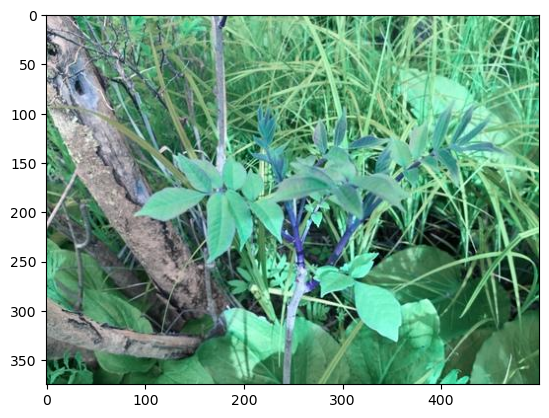

In [131]:
# Basic image plotting with cv2
img = cv2.imread('../input/toxic-plant-classification/tpc-imgs/toxic_images/004/000.jpg')
plt.imshow(img)

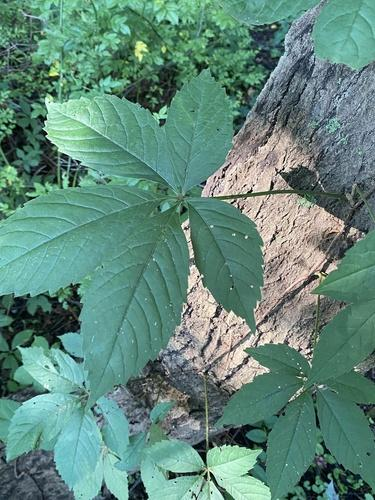

In [132]:
# Basic image viewing with PIL
DIR_0 = nontoxic_meta.loc[0, "path"]
img="010.jpg"
PIL.Image.open(DIR_0+img)

In [133]:
# Plot images from any given category
def plot_random_images(metadata, class_id, n_images=12, dims=[3,4], random_seed=12):
    """
    Function randomly selects images from the given class and plots them.
    """
    random.seed(random_seed)
    # Randomly sample n image filenames between 0 and 300
    image_files = []
    for _ in range(n_images):
        ##add 0s as necessary to acquire correct filename
        imgname = random.randint(0, 300)
        if imgname < 10:
            imgname = "00"+str(imgname)
        elif 9 < imgname < 100:
            imgname = "0"+str(imgname)
        elif imgname > 99:
            imgname = str(imgname)
        image_files.append(imgname+".jpg") ##append filename to list
    #Go to each image and read in with cv2
    image_path = metadata.loc[int(class_id), "path"] ##extract path from meta data
    imgs = []
    for img in image_files:
        ##for each image, read with cv2, recolor, add to list of images
        im = cv2.imread(os.path.join(image_path,img))
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB) ##convert color to RGB from cv2's BGR default
        imgs.append(im)
    #Get other information for the class
    slang = metadata.loc[int(class_id), "slang"]
    sci_name = metadata.loc[int(class_id), "scientific_name"]

    # Prepare figures/axes for subplots
    fig, axes = plt.subplots(dims[0], dims[1], figsize=(10,10))
    axes = axes.flatten()
    # For each image, plot image to a subplot and title with category + scientific name
    for img, ax, file in zip(imgs, axes, image_files):
        ax.imshow(img)
        ax.axis('off')
        ax.title.set_text(file)
    plt.suptitle(slang+". "+str(sci_name)+". Class ID: "+ str(class_id))
    plt.show()

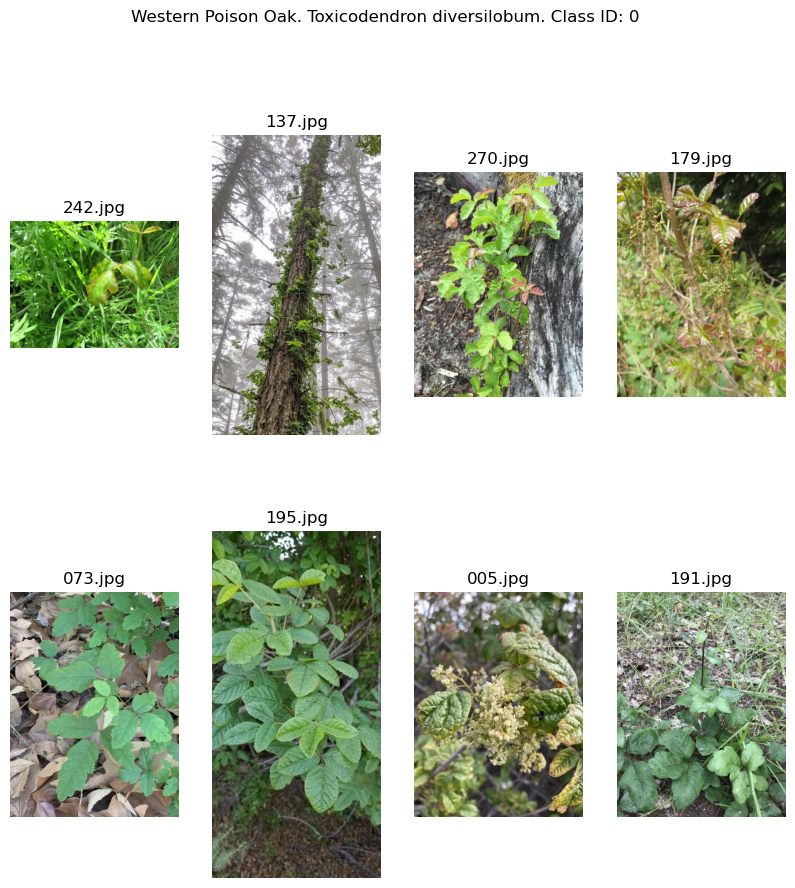

In [134]:
plot_random_images(toxic_meta, 0, n_images=8, dims=[2,4])

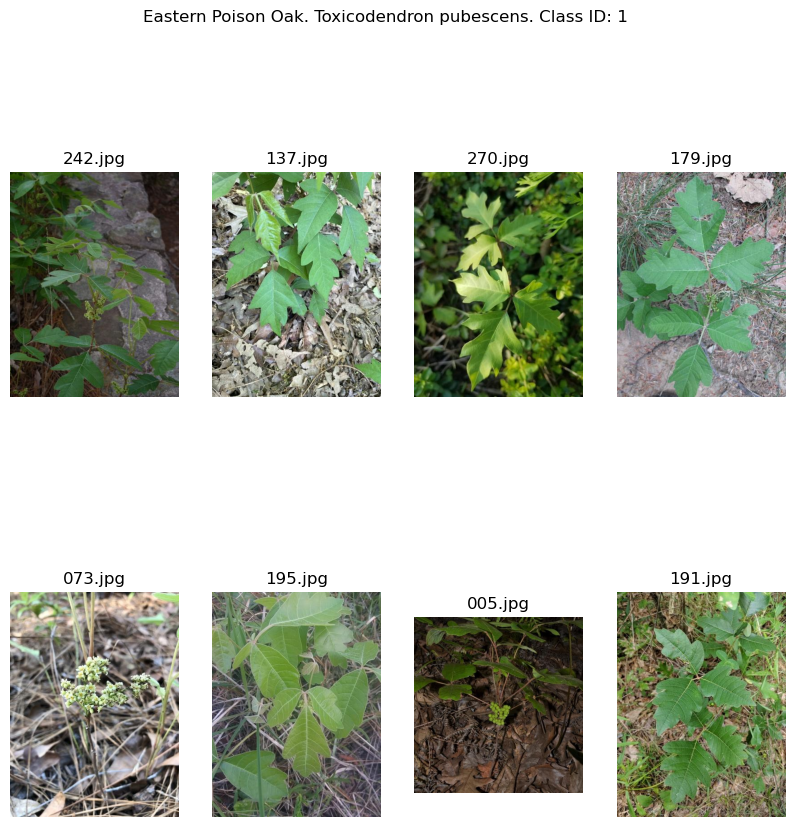

In [135]:
plot_random_images(toxic_meta, 1, n_images=8, dims=[2,4])

In [136]:
def preprocess_image(img, bright_threshold=0.25, bright_value=30, image_size=(199,199)):
    #Recolor
    im = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #Adjust brightness
    hsv = cv2.cvtColor(im, cv2.COLOR_RGB2HSV)
    mean_val = np.mean(hsv[:,:,2])/255 #as a percentage of maximum pixel value
    if mean_val <= bright_threshold:
        h, s, v = cv2.split(hsv)
        lim = 255 - bright_value
        v[v > lim] = 255
        v[v <= lim] += bright_value
        final_hsv = cv2.merge((h, s, v))
        im = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2RGB)
    #Resize
    im = cv2.resize(im, (199, 199), interpolation = cv2.INTER_AREA)

    return im

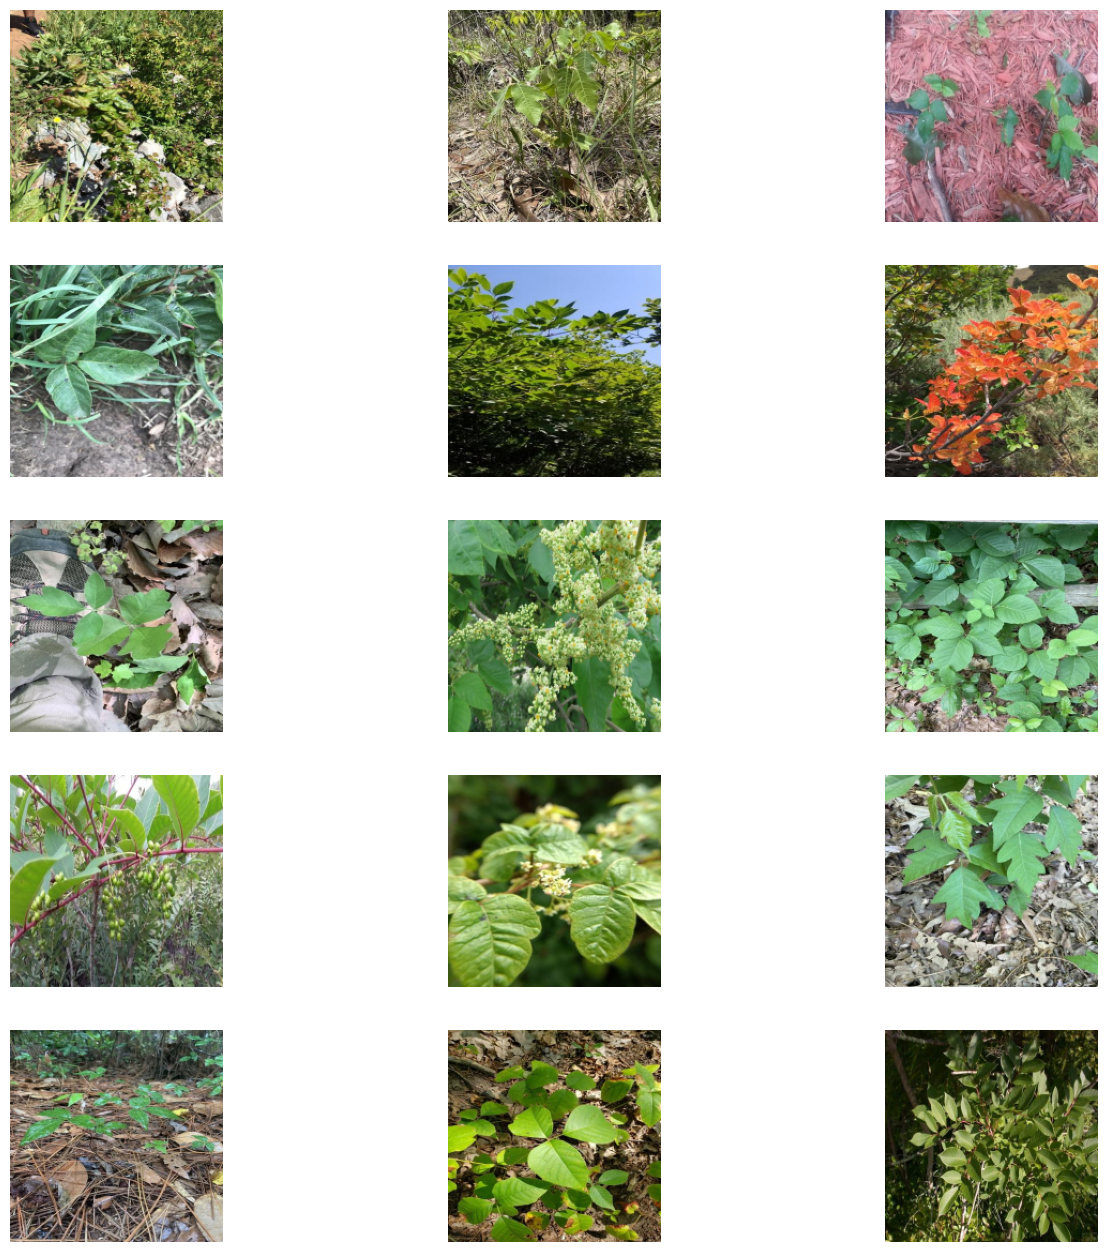

In [137]:
imgs = []
for i, p in [(i, p) for i in range(3) for p in toxic_meta['path']]:
    #randomly select 3 images of each class, read in with cv2, store in list
    randint = random.randint(100, 300)
    im = cv2.imread(p+str(randint)+".jpg")
    imgs.append(im)


fig, axes = plt.subplots(5, 3, figsize=(16,16))
axes = axes.flatten()
# For each image, apply the preprocessor function and plot image to a subplot
for img, ax in zip(imgs, axes):
    img = preprocess_image(img)
    ax.imshow(img)
    ax.axis('off')

plt.show()